In [ ]:
from IPython import get_ipython
from IPython.display import display
from random import choice, randint

class Node:
    def __init__(self, position, path_cost=1):
        self.start = False
        self.goal = False
        self.position = position
        self.children = []
        self.go = True
        self.path_cost = path_cost
        self.heuristic = float("inf")
        self.parent = None
        self.cost = float("inf")

    def __lt__(self, other):
        if self.heuristic is None or other.heuristic is None:
            return False
        return self.heuristic < other.heuristic

def tree_creation(row, col):
    tree = {}
    for i in range(row):
        for j in range(col):
            tree[(i, j)] = Node((i, j))

    for i in range(row):
        for j in range(col):
            node = tree[(i, j)]
            if node.go:
                neighbors = [
                    (i, j + 1), (i, j - 1), (i + 1, j), (i - 1, j),
                    # (i - 1, j - 1), (i - 1, j + 1), (i + 1, j - 1), (i + 1, j + 1)
                ]
                for nx, ny in neighbors:
                    if 0 <= nx < row and 0 <= ny < col:
                        neighbor_node = tree[(nx, ny)]
                        if neighbor_node.go:
                            node.children.append(neighbor_node)

    tree[0, 0].start = True

    while True:
        rand_x, rand_y = randint(0, row - 1), randint(0, col - 1)
        if (rand_x, rand_y) != (0, 0):
            goal_position = (rand_x, rand_y)
            tree[goal_position].goal = True
            break

    return tree, goal_position

def building(tree, row, col):
    building_count = 0
    building_per = int(0.17 * (row * col))  # 17% of the grid will be obstacles
    while building_count < building_per:
        i, j = randint(0, row - 1), randint(0, col - 1)
        building_node = tree[(i, j)]
        if building_node.go and not building_node.goal and not building_node.start:
            building_node.go = False
            building_node.path_cost = float('inf')
            building_count += 1
    return tree

def assign_cost(tree, row, col):
    for i in range(row):
        for j in range(col):
            node = tree[(i, j)]
            if node.go and not node.goal and not node.start:
                node.path_cost = choice([1, 2])
    return tree


In [ ]:
class QLearningAgent:
    def __init__(self, grid, start, goal, learning_rate=0.1, discount_factor=0.9, epsilon=0.1):
        self.grid = grid
        self.start = start
        self.goal = goal
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.q_table = {}
        self.initialize_q_table()

    def initialize_q_table(self):
        for state in self.grid:
            self.q_table[state] = {action: 0 for action in self.get_possible_actions(state)}

    def get_possible_actions(self, state):
        actions = []
        x, y = state
        max_x = max(pos[0] for pos in self.grid)
        max_y = max(pos[1] for pos in self.grid)
        if x > 0 and self.grid[(x - 1, y)].go:
            actions.append((-1, 0))
        if x < max_x and self.grid[(x + 1, y)].go:
            actions.append((1, 0))
        if y > 0 and self.grid[(x, y - 1)].go:
            actions.append((0, -1))
        if y < max_y and self.grid[(x, y + 1)].go:
            actions.append((0, 1))
        return actions

    #epsilon-greedy policy
    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(list(self.q_table[state].keys()))
        else:
            return max(self.q_table[state], key=self.q_table[state].get)

    def update_q_value(self, state, action, reward, next_state):
        best_next_action = max(self.q_table[next_state], key=self.q_table[next_state].get, default=0)
        self.q_table[state][action] = (1 - self.learning_rate) * self.q_table[state][action] + \
                                      self.learning_rate * (reward + self.discount_factor * self.q_table[next_state][best_next_action])

    def get_reward(self, state, action):
        next_state = (state[0] + action[0], state[1] + action[1])
        if next_state == self.goal:
            return 100
        elif not self.grid[next_state].go:
            return -100
        else:
            return -1

    def train(self, episodes, print_interval=100):
        for episode in range(episodes):
            state = self.start
            total_reward = 0
            steps = 0
            while state != self.goal:
                action = self.choose_action(state)
                next_state = (state[0] + action[0], state[1] + action[1])
                reward = self.get_reward(state, action)
                total_reward += reward
                self.update_q_value(state, action, reward, next_state)
                state = next_state
                steps += 1
                if steps > 500:
                    break
            if episode % print_interval == 0:
                print(f"Episode {episode}: Total Reward: {total_reward}")

    def get_policy(self):
        policy = {}
        for state in self.grid:
            if state != self.goal and self.q_table[state]:
                policy[state] = max(self.q_table[state], key=self.q_table[state].get)
        return policy

def extract_path_from_policy(policy, start, goal):
    path = [start]
    current = start
    while current != goal:
        if current not in policy:
            break
        action = policy[current]
        next_state = (current[0] + action[0], current[1] + action[1])
        path.append(next_state)
        current = next_state
    return path


In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

def visualize_path(grid, path, start, goal, title):
    max_row = max(key[0] for key in grid) + 1
    max_col = max(key[1] for key in grid) + 1

    grid_array = np.zeros((max_row, max_col), dtype=int)

    for (x, y), node in grid.items():
        if not node.go:
            grid_array[x, y] = 0
        if node.path_cost == 1:
            grid_array[x, y] = 1
        if node.path_cost == 2:
            grid_array[x, y] = 2

    for (x, y) in path:
        grid_array[x, y] = 3

    grid_array[start[0], start[1]] = 4
    grid_array[goal[0], goal[1]] = 5

    cmap = ListedColormap(['violet', 'lightblue', 'darkblue', 'green', 'red', 'yellow'])
    bounds = [0, 1, 2, 3, 4, 5]
    norm = plt.Normalize(vmin=0, vmax=5)

    plt.imshow(grid_array, cmap=cmap, norm=norm)
    cbar = plt.colorbar(
        ticks=[0, 1, 2, 3, 4, 5],
        format=plt.FuncFormatter(lambda val, loc: ['Obstacle', 'Low Cost', 'High Cost', 'Path', 'Start', 'Goal'][int(val)])
    )
    cbar.ax.set_ylabel('Legend', rotation=-90, labelpad=20)
    plt.title(title)
    plt.show()

In [ ]:
def heuristic_2(current, goal):
    return abs(current[0] - goal[0]) + abs(current[1] - goal[1])


def heuristic(a, b):
     return max(abs(a[0] - b[0]), abs(a[1] - b[1]))


In [ ]:
from collections import deque

#from problem import *
def bfs(tree, start, goal, row, col):

    frontier = deque([tree[start]])
    visited = set()

    max_fsize = 1

    visited.add(start)
    tree[start].parent = None
    path = []

    while frontier:
        node = frontier.popleft()

        if node.position == goal:
            while node is not None:
                path.append(node.position)
                node = node.parent
            path.reverse()
            return path, max_fsize

        for child in node.children:
            x,y = child.position
            if (x, y) not in visited and child.go:
                visited.add((x,y))
                child.parent = node
                frontier.append(child)

        max_fsize = max(max_fsize, len(frontier))

    # when no path
    return path, max_fsize


In [ ]:
from collections import deque

#from problem import *
def dfs(tree, start, goal, row, col):

    frontier = [tree[start]]
    visited = set()

    max_fsize = 1

    visited.add(start)
    tree[start].parent = None
    path = []
    while frontier:
        node = frontier.pop()

        if node.position == goal:
            while node is not None:
                path.append(node.position)
                node = node.parent
            path.reverse()
            return path, max_fsize

        #node expansion
        for child in node.children:
            x,y = child.position
            if (x, y) not in visited and child.go:
                visited.add((x,y))
                child.parent = node
                frontier.append(child)

        max_fsize = max(max_fsize, len(frontier))

    # when no path
    return path, max_fsize


In [ ]:
import heapq

def ucs(grid, start, goal, row, col):
    frontier = []
    heapq.heappush(frontier, (0, grid[start]))
    explored = set()
    max_frontier_size = 1

    while frontier:
        current_cost, current_node = heapq.heappop(frontier)

        if current_node.position == goal:
            path = []
            while current_node is not None:
                path.append(current_node.position)
                current_node = current_node.parent
            return path, max_frontier_size, current_cost

        explored.add(current_node.position)

        for child in current_node.children:
            if child.go and child.position not in explored:
                new_cost = current_cost + child.path_cost

                heapq.heappush(frontier, (new_cost, child))

                if child.parent is None or new_cost < child.path_cost:
                    child.parent = current_node

        max_frontier_size = max(max_frontier_size, len(frontier))

    return None, max_frontier_size, float('inf')



In [ ]:
#from problem import *

def ids(tree, start, goal, row, col, max_depth=1000):

    def layered_dfs(tree, start, goal, limit):
        frontier = [(tree[start], 0)]
        visited = set()
        tree[start].parent = None
        max_frontier_size = 1

        while frontier:
            max_frontier_size = max(max_frontier_size, len(frontier))
            node, current_depth = frontier.pop()
            if current_depth > limit:
                continue

            if node.position == goal:
                path = []
                while node is not None:
                    path.append(node.position)
                    node = node.parent
                path.reverse()
                return path, max_frontier_size

            visited.add(node.position)
            for child in node.children:
                x, y = child.position
                if child.position not in visited and child.go:
                    child.parent = node
                    frontier.append((child, current_depth + 1))

        return None, max_frontier_size

    max_frontier_size = 0
    for depth in range(max_depth):
        result, frontier_size = layered_dfs(tree, start, goal, depth)
        max_frontier_size = max(max_frontier_size, frontier_size)

        if result is not None:
            return result, max_frontier_size

    return None, max_frontier_size


In [ ]:
from heapq import heappop, heappush
#from heuristicFunction import *

def astar_search(tree, start_position, goal_position, h=None, verbose=False):
    if h is None:
        h = heuristic

    start_node = tree[start_position]

    start_node.heuristic = h(start_node.position, goal_position)

    frontier = [(start_node.heuristic, 0, start_node)]

    explored = set()
    max_frontier_size = 1

    if verbose:
        print("Starting A* ----->> ")

    while frontier:
        _, _, node = heappop(frontier)
        if node.goal:
            return solution(node), max_frontier_size

        explored.add(node.position)
        for child in node.children:
            if not child.go:
                continue
            f = node.path_cost + h(child.position, goal_position)
            child.heuristic = f
            if child.position not in explored and all(c.position != child.position for _, _, c in frontier):
                child.parent = node

                heappush(frontier, (f, len(explored), child))

                if child.goal:
                    return solution(child), max_frontier_size

        max_frontier_size = max(max_frontier_size, len(frontier))

        if verbose:
            pass
    return None, max_frontier_size

def solution(node):
    path = []
    while node is not None:
        path.append(node.position)
        node = node.parent
    return path[::-1]


In [ ]:
#from A_star import *

def greedy_best_first_search(tree, start_position, goal_position, h=None, verbose=False):
    if h is None:
        h = heuristic

    start_node = tree[start_position]

    start_node.heuristic = h(start_node.position, goal_position)

    frontier = [(start_node.heuristic, 0, start_node)]

    explored = set()
    max_frontier_size = 1

    if verbose:
        print("Starting Greedy Best-First Search ----->> ")

    while frontier:
        _, _, node = heappop(frontier)
        if node.goal:
            return solution(node), max_frontier_size

        explored.add(node.position)
        for child in node.children:
            if not child.go:
            #avoid obstacles
                continue

            f = h(child.position, goal_position)
            child.heuristic = f
            # Set the heuristic value for the child node
            # GBFS ملهاش استخدام في path cost ال
            if child.position not in explored and all(c.position != child.position for _, _, c in frontier):
                child.parent = node
                # Set the parent of the child node

                heappush(frontier, (f, len(explored), child))
                # Use len(explored) as a tiebreaker

                if child.goal: #current child(node) is goal ?
                    return solution(child), max_frontier_size

        max_frontier_size = max(max_frontier_size, len(frontier))

        if verbose:
            pass
    return None, max_frontier_size


In [ ]:
# from heuristicFunction import *

def hill_climbing(problem, start, goal):
    current_node = problem[start]
    goal_node = problem[goal]
    path = [current_node.position]

    while current_node.position != goal_node.position:
        neighbours = []
        for neighbour in current_node.children:
            if neighbour.go:
                neighbours.append(neighbour)

        if not neighbours:
            print("No path found")
            return path

        next_node = min(neighbours, key=lambda node: heuristic_2(node.position, goal_node.position))

        if heuristic_2(next_node.position, goal_node.position) >= heuristic_2(current_node.position, goal_node.position):
            print("Stuck in local maximum")
            return path

        current_node = next_node
        path.append(current_node.position)

    return path

In [ ]:
import random
from math import exp
#from heuristicFunction import *

def simulated_annealing(problem, start, goal):
    current_node = problem[start]
    goal_node = problem[goal]
    path = [current_node.position]
    current_node.cost = heuristic_2(current_node.position, goal_node.position)
    T = 1000

    while current_node.position != goal_node.position:
        if T == 0:
            print("Temperature reached zero, stopping.")
            return path

        neighbours = []
        for neighbour in current_node.children:
            if neighbour.go:
                neighbours.append(neighbour)

        if not neighbours:
            print("No path found")
            return path

        rand_neighbour = random.choice(neighbours)
        rand_cost = heuristic_2(rand_neighbour.position, goal_node.position)
        delta_e = rand_cost - current_node.cost

        if delta_e < 0 or random.random() < exp(-delta_e/T):
            current_node = rand_neighbour
            current_node.path = rand_cost
            path.append(current_node.position)


        T *= 0.99

    print("Goal reached!")
    return path

In [ ]:
import random

def recombine(x, y):
    n = len(x)
    c = random.randint(0, n - 1)
    return x[:c] + y[c:]

def mutate(x, gene_pool, pmut):
    if random.uniform(0, 1) >= pmut:
        return x

    n = len(x)
    g = len(gene_pool)
    c = random.randint(0, n - 1)
    r = random.randint(0, g - 1)
    new_gene = gene_pool[r]
    return x[:c] + [new_gene] + x[c + 1:]

def init_population(pop_number, gene_pool, state_length, start, goal):
    population = []
    for _ in range(pop_number):
        new_individual = [start]
        for _ in range(state_length - 2):
            new_individual.append(random.choice(gene_pool))
        new_individual.append(goal)
        population.append(new_individual)
    return population



def fitness(path, grid, start, goal):
    if path[0] != start or path[-1] != goal:
        return 0.01

    cost = 0
    for i in range(len(path) - 1):
        current = path[i]
        next_node = path[i + 1]

        if next_node in grid[current].children and grid[next_node].go:
            cost += grid[next_node].path_cost
        else:
            return 0.01

    return 1 / (1 + cost)

def select(k, population, fitness_fn, grid, start, goal):
    selected = random.choices(population, k=k, weights=[fitness_fn(ind, grid, start, goal) for ind in population])
    selected = sorted(selected, key=lambda x: fitness_fn(x, grid, start, goal), reverse=True)
    return selected[:2]

def genetic_algorithm(population, fitness_fn, grid, start, goal, gene_pool, f_thres, ngen=1000, pmut=0.1):
    for i in range(ngen):
        population = [
            mutate(recombine(*select(2, population, fitness_fn, grid, start, goal)), gene_pool, pmut)
            for _ in range(len(population))
        ]

        fittest_individual = max(population, key=lambda ind: fitness_fn(ind, grid, start, goal))
        if fitness_fn(fittest_individual, grid, start, goal) >= f_thres:
            print(f"Solution found at generation {i + 1}")
            return fittest_individual
    return max(population, key=lambda ind: fitness_fn(ind, grid, start, goal))



In [ ]:

from time import time
# from A_star import *
# from greedy_best_first import *
def measure_performance(search_algorithm, problem, start_position, goal_position, verbose=False):

    start_time = time()

    solution_result, max_frontier_size = search_algorithm(problem, start_position, goal_position, verbose=verbose)

    elapsed_time = time() - start_time

    return {
        'solution': solution_result,
        'elapsed_time': elapsed_time,
        'max_frontier_size': max_frontier_size
    }


def astar_performance(tree, start_position, goal_position, verbose=False):
    performance = measure_performance(astar_search, tree, start_position, goal_position, verbose=verbose)

    solution = performance['solution']
    elapsed_time = performance['elapsed_time']
    max_frontier_size = performance['max_frontier_size']

    print("A* Search Performance:")
    print(f"Solution: {solution}")
    print(f"Elapsed Time: {elapsed_time:.4f} seconds")
    print(f"Max Frontier Size: {max_frontier_size}")

    total_nodes = len(tree)
    explored_percentage = (max_frontier_size / total_nodes) * 100
    print(f"Explored Nodes Percentage: {explored_percentage:.2f}%")

    return performance

def gbfs_performance(tree, start_position, goal_position, verbose=False):
    performance = measure_performance(greedy_best_first_search, tree, start_position, goal_position, verbose=verbose)

    solution = performance['solution']
    elapsed_time = performance['elapsed_time']
    max_frontier_size = performance['max_frontier_size']

    print("Greedy Best-First Search Performance:")
    print(f"Solution: {solution}")
    print(f"Elapsed Time: {elapsed_time:.4f} seconds")
    print(f"Max Frontier Size: {max_frontier_size}")

    total_nodes = len(tree)
    explored_percentage = (max_frontier_size / total_nodes) * 100
    print(f"Explored Nodes Percentage: {explored_percentage:.2f}%")

    return performance


In [ ]:
    # Uninformed Search
    # '''
    # # BFS
    # t_bfs = time.time()
    # bfs_, max_fsize = bfs(grid_with_costs, start, goal, 40, 40)
    # t_bfs2 = time.time()
    # print(f"BFS Path: {bfs_}")
    # print(f"time taken: {round((t_bfs2-t_bfs) * 1e3, 3)} milliseconds")
    # visualize_path(grid_with_costs, bfs_, start, goal, "Breadth First Search")

    # # DFS
    # t_dfs = time.time()
    # dfs_, max_frontier = dfs(grid_with_costs, start, goal, 40, 40)
    # t_dfs2 = time.time()
    # print(f"DFS Path: {dfs_}")
    # print(f"time taken: {round((t_dfs2 - t_dfs) * 1e3, 3)} milliseconds")
    # visualize_path(grid_with_costs, dfs_, start, goal, "Depth First Search")

    # # IDS
    # t_ids = time.time()
    # ids_, max_front = ids(grid_with_costs, start, goal, 40, 40, 1000)
    # t_ids2 = time.time()
    # print(f"IDS Path: {ids_}")
    # print(f"time taken: {round((t_ids2 - t_ids) * 1e3, 3)} milliseconds")
    # visualize_path(grid_with_costs, ids_, start, goal, "Iterative Deepening Search")

    # # UCS
    # t_ucs = time.time()
    # usc_, max_frontier_s, cost = ucs(grid_with_costs, start, goal, 40, 40)
    # t_ucs2 = time.time()
    # print(f"UCS Path: {usc_}")
    # print(f"time taken: {round((t_ucs2 - t_ucs) * 1e3, 3)} milliseconds")
    # visualize_path(grid_with_costs, usc_, start, goal, "UCS Search")

    # '''
    # Informed Search
    # '''
    # # A*
    # t_astar = time.time()
    # a_star_, max_frontier_size = astar_search(grid_with_costs, start, goal, h=heuristic, verbose=True)
    # t_astar2 = time.time()
    # print(f"A* Path: {a_star_}")
    # print(f"time taken: {round((t_astar2 - t_astar) * 1e3, 3)} milliseconds")
    # visualize_path(grid_with_costs, a_star_, start, goal, "A* Search")

    # # Greedy Best First Search
    # t_gbst = time.time()
    # gbfs, max_frontier_ = greedy_best_first_search(grid_with_costs, start, goal, h=heuristic, verbose=True)
    # t_gbst2 = time.time()
    # print(f"GBFS Path: {gbfs}")
    # print(f"time taken: {round((t_gbst2 - t_gbst) * 1e3, 3)} milliseconds")
    # visualize_path(grid_with_costs, gbfs, start, goal, "Greedy Best First Search")

    # '''
    # Local Search
    # '''
    # # Simulated Annealing
    # t_sa = time.time()
    # simulated__annealing = simulated_annealing(grid_with_costs, start, goal)
    # t_sa2 = time.time()
    # print(f"SA Path: {simulated__annealing}")
    # print(f"time taken: {round((t_sa2 - t_sa) * 1e3, 3)} milliseconds")
    # visualize_path(grid_with_costs, simulated__annealing, start, goal, "Simulated Annealing")

    # # Hill Climbing
    # t_hc = time.time()
    # hill__climbing = simulated_annealing(grid_with_costs, start, goal)
    # t_hc2 = time.time()
    # print(f"HC Path: {hill__climbing}")
    # print(f"time taken: {round((t_hc2 - t_hc) * 1e3, 3)} milliseconds")
    # visualize_path(grid_with_costs, hill__climbing, start, goal, "Hill Climbing")

    # # Genetic Algorithm
    # t_ga = time.time()
    # gene_pool = list(grid_with_costs.keys())
    # population = init_population(100, gene_pool, state_length=20, start=start, goal=goal)
    # genetic_path = genetic_algorithm(population, fitness, grid_with_costs, start, goal, gene_pool, f_thres=0.5, ngen=1000, pmut=0.1)
    # t_ga2 = time.time()
    # print(f"Genetic Algorithm Path: {genetic_path}")
    # print(f"time taken: {round((t_ga2 - t_ga) * 1e3, 3)} milliseconds")
    # visualize_path(grid_with_costs, genetic_path, start, goal, "Genetic Algorithm")

    # tree = grid_with_costs  # Assuming grid_with_costs is your graph structure
    # start_position = start
    # goal_position = goal

    # Measure A* performance
    # astar_performance(tree, start_position, goal_position, verbose=True)

    # # Measure GBFS performance
    # gbfs_performance(tree, start_position, goal_position, verbose=True)

Goal placed at: (34, 2)
BFS Path: [(0, 0), (1, 0), (1, 1), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (10, 2), (11, 2), (12, 2), (13, 2), (14, 2), (15, 2), (16, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (23, 2), (24, 2), (25, 2), (26, 2), (27, 2), (28, 2), (29, 2), (30, 2), (31, 2), (31, 3), (32, 3), (33, 3), (34, 3), (34, 2)]
time taken: 2.066 milliseconds


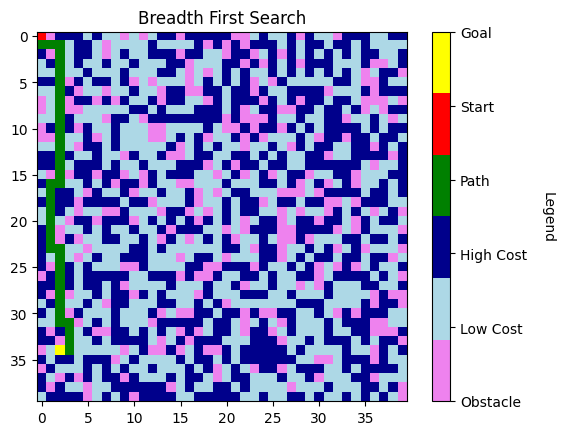

DFS Path: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (10, 2), (11, 2), (12, 2), (13, 2), (14, 2), (15, 2), (16, 2), (17, 2), (18, 2), (19, 2), (20, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (24, 2), (25, 2), (26, 2), (27, 2), (28, 2), (29, 2), (30, 2), (31, 2), (32, 2), (32, 3), (33, 3), (34, 3), (34, 2)]
time taken: 9.656 milliseconds


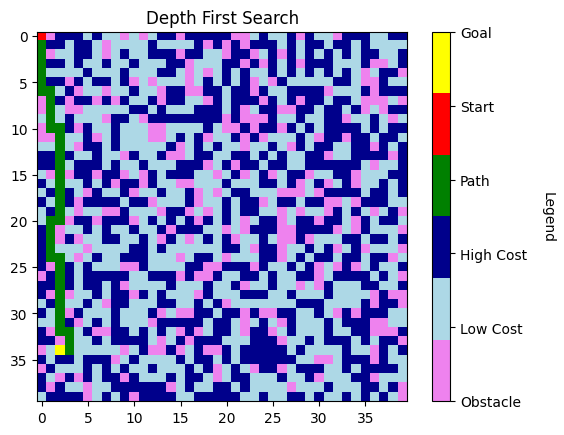

IDS Path: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (6, 1), (5, 1), (4, 1), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (10, 2), (11, 2), (12, 2), (13, 2), (14, 2), (15, 2), (16, 2), (17, 2), (18, 2), (19, 2), (20, 2), (20, 1), (19, 1), (18, 1), (17, 1), (16, 1), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (24, 1), (23, 1), (23, 2), (24, 2), (25, 2), (26, 2), (27, 2), (28, 2), (29, 2), (30, 2), (31, 2), (32, 2), (32, 3), (33, 3), (34, 3), (34, 2)]
time taken: 40.535 milliseconds


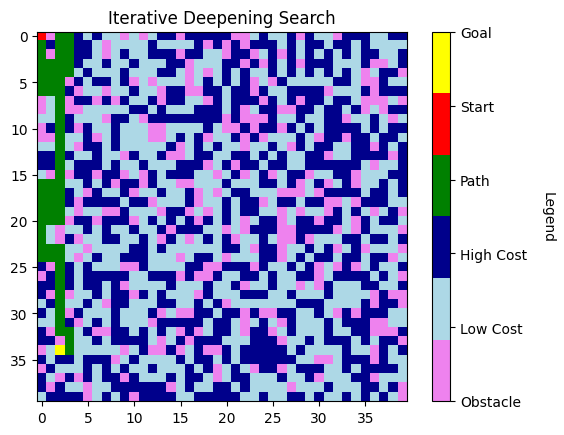

UCS Path: [(34, 2), (34, 3), (33, 3), (32, 3), (32, 2), (31, 2), (30, 2), (29, 2), (28, 2), (27, 2), (26, 2), (25, 2), (24, 2), (23, 2), (23, 1), (24, 1), (24, 0), (23, 0), (22, 0), (21, 0), (20, 0), (19, 0), (18, 0), (17, 0), (16, 0), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (20, 2), (19, 2), (18, 2), (17, 2), (16, 2), (15, 2), (14, 2), (13, 2), (12, 2), (11, 2), (10, 2), (9, 2), (8, 2), (7, 2), (6, 2), (5, 2), (4, 2), (4, 3), (3, 3), (2, 3), (1, 3), (0, 3), (0, 2), (1, 2), (2, 2), (3, 2), (3, 1), (4, 1), (5, 1), (6, 1), (6, 0), (5, 0), (4, 0), (3, 0), (2, 0), (1, 0), (0, 0)]
time taken: 1955.883 milliseconds


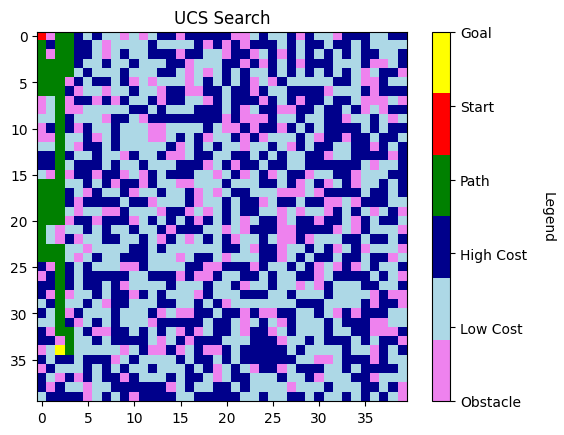

Starting A* ----->> 
A* Path: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (10, 2), (11, 2), (12, 2), (13, 2), (14, 2), (15, 2), (16, 2), (17, 2), (18, 2), (19, 2), (20, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (24, 2), (25, 2), (26, 2), (27, 2), (28, 2), (29, 2), (30, 2), (31, 2), (32, 2), (32, 3), (33, 3), (34, 3), (34, 2)]
time taken: 0.726 milliseconds


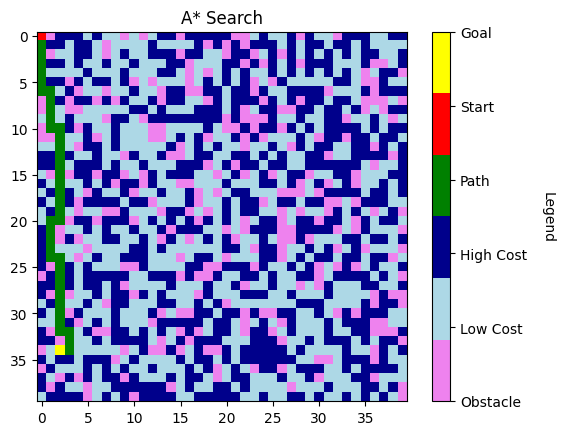

Starting Greedy Best-First Search ----->> 
GBFS Path: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (10, 2), (11, 2), (12, 2), (13, 2), (14, 2), (15, 2), (16, 2), (17, 2), (18, 2), (19, 2), (20, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (24, 2), (25, 2), (26, 2), (27, 2), (28, 2), (29, 2), (30, 2), (31, 2), (32, 2), (32, 3), (33, 3), (34, 3), (34, 2)]
time taken: 0.652 milliseconds


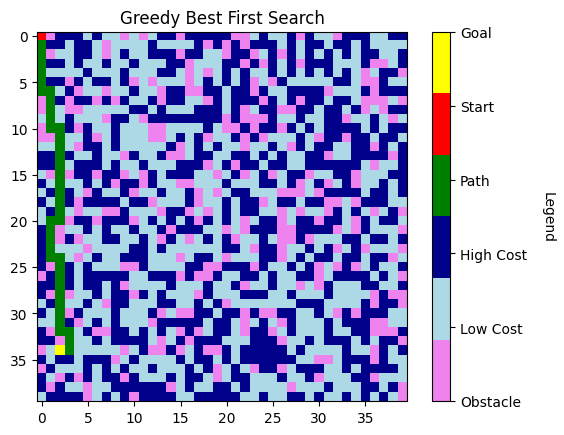

Goal reached!
SA Path: [(0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 0), (3, 1), (4, 1), (4, 2), (4, 3), (4, 2), (5, 2), (4, 2), (4, 3), (3, 3), (3, 4), (2, 4), (3, 4), (3, 3), (4, 3), (4, 4), (5, 4), (5, 5), (5, 6), (6, 6), (5, 6), (4, 6), (4, 7), (5, 7), (4, 7), (4, 6), (5, 6), (5, 7), (4, 7), (5, 7), (4, 7), (4, 6), (4, 5), (3, 5), (3, 4), (3, 5), (2, 5), (1, 5), (1, 6), (1, 5), (0, 5), (0, 6), (1, 6), (2, 6), (2, 5), (2, 6), (2, 5), (2, 4), (2, 5), (2, 4), (2, 3), (1, 3), (0, 3), (0, 2), (1, 2), (0, 2), (0, 3), (0, 4), (1, 4), (1, 3), (2, 3), (3, 3), (3, 4), (3, 3), (3, 4), (4, 4), (3, 4), (2, 4), (2, 5), (1, 5), (2, 5), (2, 4), (3, 4), (3, 3), (3, 4), (3, 3), (3, 4), (4, 4), (5, 4), (5, 5), (4, 5), (5, 5), (5, 4), (4, 4), (5, 4), (4, 4), (4, 3), (3, 3), (2, 3), (3, 3), (3, 4), (2, 4), (3, 4), (3, 3), (4, 3), (4, 4), (4, 5), (4, 4), (4, 5), (5, 5), (4, 5), (4, 4), (4, 5), (3, 5), (2, 5), (2, 4), (2, 5), (2, 6), (2, 5), (2, 6), (3, 6), (3, 7), (3, 6), (3, 5), (3, 6), (2, 6), (3, 6), 

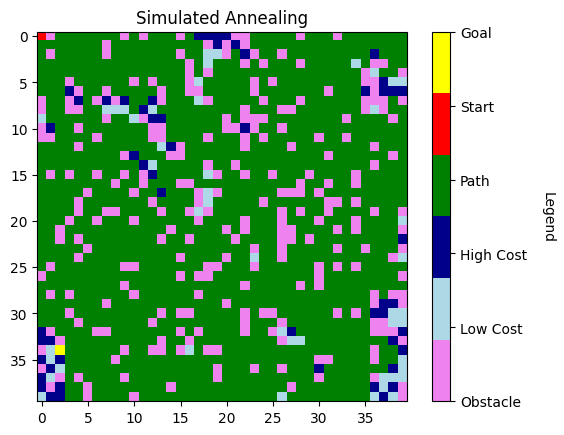

Goal reached!
HC Path: [(0, 0), (1, 0), (1, 1), (1, 0), (1, 1), (1, 0), (1, 1), (1, 0), (2, 0), (1, 0), (1, 1), (1, 0), (2, 0), (3, 0), (4, 0), (4, 1), (3, 1), (4, 1), (3, 1), (4, 1), (4, 2), (4, 1), (4, 2), (3, 2), (4, 2), (5, 2), (6, 2), (6, 3), (6, 2), (7, 2), (8, 2), (8, 1), (8, 2), (9, 2), (9, 1), (8, 1), (7, 1), (6, 1), (5, 1), (5, 2), (6, 2), (6, 1), (6, 2), (6, 3), (6, 2), (6, 3), (6, 2), (6, 3), (6, 2), (7, 2), (8, 2), (9, 2), (8, 2), (8, 1), (8, 2), (7, 2), (6, 2), (7, 2), (8, 2), (9, 2), (10, 2), (9, 2), (10, 2), (10, 1), (9, 1), (10, 1), (10, 2), (11, 2), (12, 2), (11, 2), (12, 2), (11, 2), (11, 3), (11, 4), (11, 5), (11, 4), (11, 5), (10, 5), (9, 5), (10, 5), (11, 5), (11, 4), (11, 5), (12, 5), (13, 5), (13, 4), (14, 4), (13, 4), (14, 4), (13, 4), (13, 5), (13, 4), (14, 4), (13, 4), (13, 3), (12, 3), (13, 3), (13, 2), (14, 2), (15, 2), (16, 2), (16, 3), (16, 2), (17, 2), (17, 1), (17, 2), (16, 2), (17, 2), (17, 3), (16, 3), (17, 3), (18, 3), (17, 3), (17, 4), (16, 4), (16,

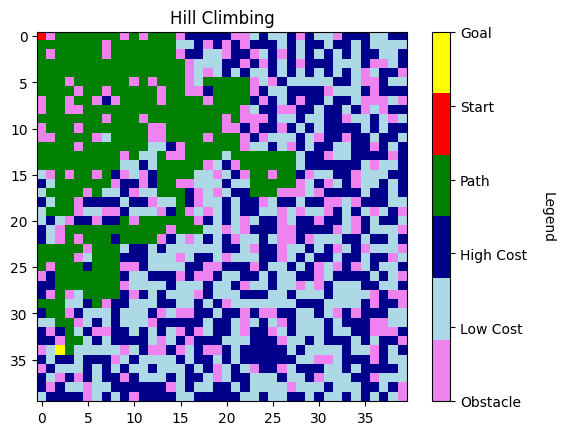

Genetic Algorithm Path: [(12, 20), (21, 0), (25, 4), (3, 32), (30, 36), (1, 34), (18, 6), (32, 22), (13, 16), (38, 0), (30, 22), (32, 2), (35, 21), (9, 21), (11, 9), (30, 38), (16, 6), (14, 36), (39, 21), (18, 20)]
time taken: 3488.091 milliseconds


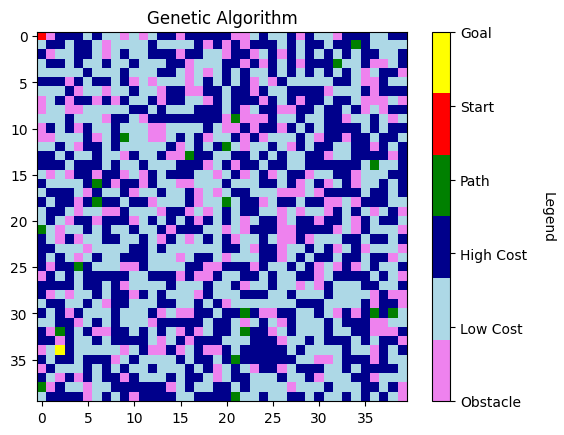

Episode 0: Total Reward: -501
Episode 100: Total Reward: -501
Episode 200: Total Reward: -211
Episode 300: Total Reward: -501
Episode 400: Total Reward: -165
Episode 500: Total Reward: -501
Episode 600: Total Reward: -501
Episode 700: Total Reward: -15
Episode 800: Total Reward: -101
Episode 900: Total Reward: 7
Episode 1000: Total Reward: -53
Episode 1100: Total Reward: 19
Episode 1200: Total Reward: -59
Episode 1300: Total Reward: -501
Episode 1400: Total Reward: 59
Episode 1500: Total Reward: 57
Episode 1600: Total Reward: 57
Episode 1700: Total Reward: 59
Episode 1800: Total Reward: 55
Episode 1900: Total Reward: 57
Episode 2000: Total Reward: 59
Episode 2100: Total Reward: 57
Episode 2200: Total Reward: 49
Episode 2300: Total Reward: 55
Episode 2400: Total Reward: 59
Episode 2500: Total Reward: 57
Episode 2600: Total Reward: 53
Episode 2700: Total Reward: 57
Episode 2800: Total Reward: 57
Episode 2900: Total Reward: 59
Episode 3000: Total Reward: 61
Episode 3100: Total Reward: 57


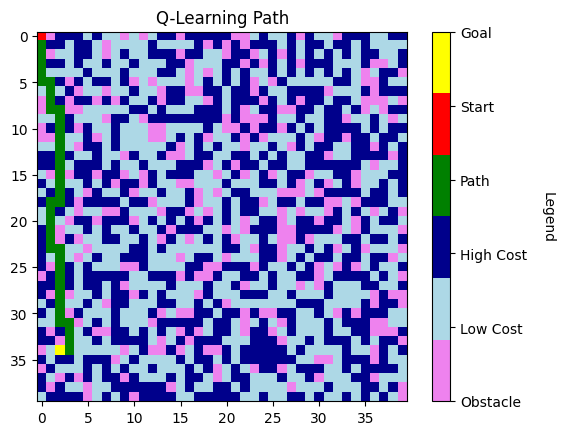

In [ ]:
import time

def main():
    maze, goal = tree_creation(40, 40)
    print(f"Goal placed at: {goal}")
    maze_with_obstacles = building(maze, 40, 40)
    assign_cost(maze_with_obstacles, 40, 40)
    grid_with_costs = maze_with_obstacles
    start = (0, 0)

    '''
    Uninformed Search
    '''
    # BFS
    t_bfs = time.time()
    bfs_, max_fsize = bfs(grid_with_costs, start, goal, 40, 40)
    t_bfs2 = time.time()
    print(f"BFS Path: {bfs_}")
    print(f"time taken: {round((t_bfs2-t_bfs) * 1e3, 3)} milliseconds")
    visualize_path(grid_with_costs, bfs_, start, goal, "Breadth First Search")

    # DFS
    t_dfs = time.time()
    dfs_, max_frontier = dfs(grid_with_costs, start, goal, 40, 40)
    t_dfs2 = time.time()
    print(f"DFS Path: {dfs_}")
    print(f"time taken: {round((t_dfs2 - t_dfs) * 1e3, 3)} milliseconds")
    visualize_path(grid_with_costs, dfs_, start, goal, "Depth First Search")

    # IDS
    t_ids = time.time()
    ids_, max_front = ids(grid_with_costs, start, goal, 40, 40, 1000)
    t_ids2 = time.time()
    print(f"IDS Path: {ids_}")
    print(f"time taken: {round((t_ids2 - t_ids) * 1e3, 3)} milliseconds")
    visualize_path(grid_with_costs, ids_, start, goal, "Iterative Deepening Search")

    # UCS
    t_ucs = time.time()
    usc_, max_frontier_s, cost = ucs(grid_with_costs, start, goal, 40, 40)
    t_ucs2 = time.time()
    print(f"UCS Path: {usc_}")
    print(f"time taken: {round((t_ucs2 - t_ucs) * 1e3, 3)} milliseconds")
    visualize_path(grid_with_costs, usc_, start, goal, "UCS Search")

    '''
    Informed Search
    '''
    # A*
    t_astar = time.time()
    a_star_, max_frontier_size = astar_search(grid_with_costs, start, goal, h=heuristic, verbose=True)
    t_astar2 = time.time()
    print(f"A* Path: {a_star_}")
    print(f"time taken: {round((t_astar2 - t_astar) * 1e3, 3)} milliseconds")
    visualize_path(grid_with_costs, a_star_, start, goal, "A* Search")

    # Greedy Best First Search
    t_gbst = time.time()
    gbfs, max_frontier_ = greedy_best_first_search(grid_with_costs, start, goal, h=heuristic, verbose=True)
    t_gbst2 = time.time()
    print(f"GBFS Path: {gbfs}")
    print(f"time taken: {round((t_gbst2 - t_gbst) * 1e3, 3)} milliseconds")
    visualize_path(grid_with_costs, gbfs, start, goal, "Greedy Best First Search")

    '''
    Local Search
    '''
    # Simulated Annealing
    t_sa = time.time()
    simulated__annealing = simulated_annealing(grid_with_costs, start, goal)
    t_sa2 = time.time()
    print(f"SA Path: {simulated__annealing}")
    print(f"time taken: {round((t_sa2 - t_sa) * 1e3, 3)} milliseconds")
    visualize_path(grid_with_costs, simulated__annealing, start, goal, "Simulated Annealing")

    # Hill Climbing
    t_hc = time.time()
    hill__climbing = simulated_annealing(grid_with_costs, start, goal)
    t_hc2 = time.time()
    print(f"HC Path: {hill__climbing}")
    print(f"time taken: {round((t_hc2 - t_hc) * 1e3, 3)} milliseconds")
    visualize_path(grid_with_costs, hill__climbing, start, goal, "Hill Climbing")

    # Genetic Algorithm
    t_ga = time.time()
    gene_pool = list(grid_with_costs.keys())
    population = init_population(100, gene_pool, state_length=20, start=start, goal=goal)
    genetic_path = genetic_algorithm(population, fitness, grid_with_costs, start, goal, gene_pool, f_thres=0.5, ngen=1000, pmut=0.1)
    t_ga2 = time.time()
    print(f"Genetic Algorithm Path: {genetic_path}")
    print(f"time taken: {round((t_ga2 - t_ga) * 1e3, 3)} milliseconds")
    visualize_path(grid_with_costs, genetic_path, start, goal, "Genetic Algorithm")

    q_agent = QLearningAgent(grid_with_costs, start, goal)

    q_agent.train(episodes=10000)

    policy = q_agent.get_policy()
    for state in list(policy.keys())[:300]:
        action = policy[state]
        next_state = (state[0] + action[0], state[1] + action[1])
        reward = q_agent.get_reward(state, action)
        print(f"State {state}: Action {action}, Next State {next_state}, Reward {reward}")

    path = extract_path_from_policy(policy, start, goal)

    visualize_path(grid_with_costs, path, start, goal, "Q-Learning Path")

def extract_path_from_policy(policy, start, goal):
    path = []
    current_state = start
    while current_state != goal:
        path.append(current_state)
        action = policy[current_state]
        current_state = (current_state[0] + action[0], current_state[1] + action[1])
    path.append(goal)
    return path

if __name__ == '__main__':
    main()


In [ ]:
# from time import time
# # from A_star import *
# # from greedy_best_first import *
# def measure_performance(search_algorithm, problem, start_position, goal_position, verbose=False):

#     start_time = time()

#     solution_result, max_frontier_size = search_algorithm(problem, start_position, goal_position, verbose=verbose)

#     elapsed_time = time() - start_time

#     return {
#         'solution': solution_result,
#         'elapsed_time': elapsed_time,
#         'max_frontier_size': max_frontier_size
#     }


# def astar_performance(tree, start_position, goal_position, verbose=False):
#     performance = measure_performance(astar_search, tree, start_position, goal_position, verbose=verbose)

#     solution = performance['solution']
#     elapsed_time = performance['elapsed_time']
#     max_frontier_size = performance['max_frontier_size']

#     print("A* Search Performance:")
#     print(f"Solution: {solution}")
#     print(f"Elapsed Time: {elapsed_time:.4f} seconds")
#     print(f"Max Frontier Size: {max_frontier_size}")

#     total_nodes = len(tree)
#     explored_percentage = (max_frontier_size / total_nodes) * 100
#     print(f"Explored Nodes Percentage: {explored_percentage:.2f}%")

#     return performance

# def gbfs_performance(tree, start_position, goal_position, verbose=False):
#     performance = measure_performance(greedy_best_first_search, tree, start_position, goal_position, verbose=verbose)

#     solution = performance['solution']
#     elapsed_time = performance['elapsed_time']
#     max_frontier_size = performance['max_frontier_size']

#     print("Greedy Best-First Search Performance:")
#     print(f"Solution: {solution}")
#     print(f"Elapsed Time: {elapsed_time:.4f} seconds")
#     print(f"Max Frontier Size: {max_frontier_size}")

#     total_nodes = len(tree)
#     explored_percentage = (max_frontier_size / total_nodes) * 100
#     print(f"Explored Nodes Percentage: {explored_percentage:.2f}%")

#     return performance


In [ ]:
# astar_performance(tree, start_position, goal_position, verbose=True)
# gbfs_performance(tree, start_position, goal_position, verbose=True)